## Use a random forest to predict the next output character given the previous inputs and outputs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import jellyfish
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

from matchers import metrics, utils, dataset
from matchers.models.randomforest import get_editpairs, get_Xy

In [3]:
np.set_printoptions(suppress=True)
tqdm.pandas()

### Load and process data

In [4]:
# Only need to run this once
# It we split the data into train/test and will persist the data on disk
# dataset.load_split_init(test_size=0.1)

In [5]:
train, test = dataset.load_process_from_disk()

input_names_train, weighted_relevant_names_train, all_candidates_train = train
input_names_test, weighted_relevant_names_test, all_candidates_test = test

all_candidates = np.concatenate((all_candidates_train, all_candidates_test))

### Model

In [6]:
train_editpairs = []

for tree_name, record_names in zip(input_names_train, weighted_relevant_names_train):
    for weighted_record_name in record_names:
        train_editpairs.append(get_editpairs(weighted_record_name[0], tree_name))

len(train_editpairs)

22541

In [7]:
# create X_train and y_train

window_size = 4

X_train, y_train = get_Xy(train_editpairs, window_size)
print(X_train.shape, y_train.shape)

(199608, 270) (199608,)


In [8]:
# fit random forest

max_depth = 30
n_estimators = 100

clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, oob_score=True, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
clf.oob_score_

0.904567953188249

In [9]:
def lev_similarity(cand_name, name):
    # jellyfish is 10x faster than Levenshtein
    # it doesn't return the edit operations, but we don't need those here
    cand_name = utils.remove_padding(cand_name)
    name = utils.remove_padding(name)
    dist = jellyfish.levenshtein_distance(name, cand_name)
    return 1 - (dist / max(len(name), len(cand_name)))

In [10]:
import warnings

lev_similarity_threshold = 0.6
no_score = -99.0

def calc_similarity_to(name):
    # score name vs name
    X, y = get_Xy([get_editpairs(name, name)], window_size)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        predictions = clf.predict_log_proba(X)
    indices = np.where(clf.classes_==y[:,None])[1]
    name_score = sum(predictions[np.arange(len(indices)), indices])

    def calc_similarity(row):
        cand_name = row[0]
        # random forest is slow; return 0 scores for names that aren't very similar
        if lev_similarity(cand_name, name) < lev_similarity_threshold:
            return no_score
        # get candidate score
        X, y = get_Xy([get_editpairs(cand_name, name)], window_size)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            predictions = clf.predict_log_proba(X)
        indices = np.where(clf.classes_==y[:,None])[1]
        cand_score = sum(predictions[np.arange(len(indices)), indices])
        # score is cand_score - name_score
        return cand_score - name_score

    return calc_similarity

#### Similarity Function

In [11]:
def get_similars(name, k=10, demo_mode=False):
    if demo_mode:
        name = utils.add_padding(name)
    scores = np.apply_along_axis(calc_similarity_to(name), 1, all_candidates[:,None])
    sorted_scores_idx = np.argsort(scores)[::-1][:k]
    candidates = all_candidates[sorted_scores_idx]
    if demo_mode:
        candidates = [utils.remove_padding(candidate) for candidate in candidates]
    candidates_scores = scores[sorted_scores_idx]
    
    return list(zip(candidates, candidates_scores))

In [12]:
calc_similarity = calc_similarity_to('<quass>')
calc_similarity(['<quast>'])

-4.493598546175214

#### Demo

In [13]:
get_similars('bostelman', 10, True)

[('bostelman', -4.440892098500626e-16),
 ('bostelmann', -0.07863752870526097),
 ('bostleman', -2.9625867655163254),
 ('bokelman', -6.438046744102918),
 ('bosman', -6.616046096964132),
 ('bothman', -7.350681507534022),
 ('bushelman', -7.738154839748606),
 ('bockelman', -8.026404327075555),
 ('baseman', -8.389334955998219),
 ('bestman', -8.73328298174307)]

## Generate scores for all test names

In [14]:
k = 100 # Number of candidates to consider
name_candidates = list(map(lambda x: get_similars(x, k=k), tqdm(input_names_test)))

100%|██████████| 2444/2444 [34:36<00:00,  1.18it/s] 


In [15]:
len(name_candidates)

2444

In [16]:
names = np.array(list(list(cell[0] for cell in row) for row in name_candidates), dtype='O')
scores = np.array(list(list(cell[1] for cell in row) for row in name_candidates), dtype='f8')
candidates = np.dstack((names, scores))

### Evaluation

#### Precision @ -4

In [31]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, candidates, -4.16)

0.6374491171903202

#### Recall @ -4

In [30]:
metrics.avg_recall_at_threshold(weighted_relevant_names_test, candidates, -4.16)

0.9002293501753196

#### Precision-Recall Curve

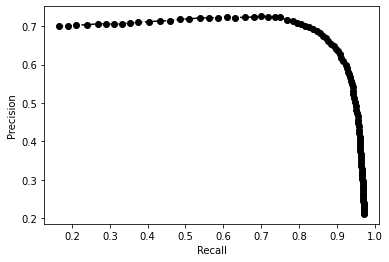

In [19]:
# minimum score threshold to test
min_threshold = -10.0
max_threshold = 0.0
step = 0.1
metrics.precision_recall_curve_at_threshold(weighted_relevant_names_test, candidates, min_threshold, max_threshold, step)

## Test

In [20]:
input_names_test[251]

'<bostelman>'

In [21]:
weighted_relevant_names_test[251]

[('<bostelmann>', 0.6784565916398714, 211),
 ('<bostleman>', 0.3215434083601286, 100)]

In [22]:
candidates[251,:5]

array([['<bostelman>', 4.440892098500626e-16],
       ['<bostelmann>', -0.07863752870526053],
       ['<bostleman>', -2.962586765516325],
       ['<bokelman>', -6.438046744102917],
       ['<bosman>', -6.61604609696413]], dtype=object)

In [24]:
metrics.recall_at_threshold(weighted_relevant_names_test[251], candidates[251], -1)

0.6784565916398714

In [25]:
metrics.recall_at_threshold(weighted_relevant_names_test[251], candidates[251], -3)

1.0